In [3]:
# Useful starting lines
import sys
import os
sys.path.insert(0, os.path.realpath('./scripts'))


from scripts import proj1_helpers, implementation, helpers

%matplotlib inline
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [4]:
from proj1_helpers import load_csv_data

train_path = './data/train.csv'

# load dataset
y,x,ids = load_csv_data(train_path)

In [5]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [6]:
print(y.shape, (lambda x: x[0] * x[1])(build_k_indices(y, 11, 1).shape))

(250000,) 249997


In [7]:
from costs import compute_mse
from ridge_regression import ridge_regression
#from build_polynomial import build_poly
from helpers import build_model_data

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""

    # building polynomial matrix for whole dataset
    #x_poly = build_poly(x, degree)
    y,tx=build_model_data(x,y)
    
    
    # indices for test
    idx_te = k_indices[k]
    
    # indices for train
    idx_tr = k_indices[np.arange(len(k_indices)) != k][0]
    
    # x data: train/test
    x_poly_tr = tx[idx_tr, :]
    x_poly_te = tx[idx_te, :]
    
    # y data: train/test
    y_tr = y[idx_tr]
    y_te = y[idx_te]
  
    # training ridge regression
    weights = ridge_regression(y_tr, x_poly_tr, lambda_)

    # computing losses
    loss_tr = compute_mse(y_tr, x_poly_tr, weights)
    loss_te = compute_mse(y_te, x_poly_te, weights)
    
    return loss_tr, loss_te

100%|██████████| 30/30 [00:09<00:00,  3.18it/s]


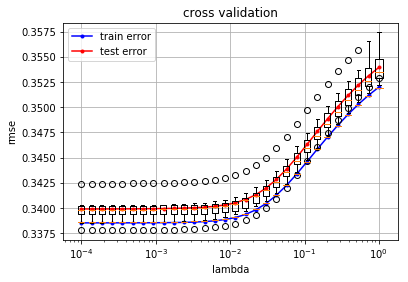

In [13]:
from plots import cross_validation_visualization

def cross_validation_demo():
    seed = 2
    degree = 7
    k_fold = 10
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr, rmse_te = [], []
    rmse = [rmse_tr, rmse_te]
    rmse_all = [[], []]
    
    for lambda_ in tqdm(lambdas):
        rmse_ = [[], []]
        for k in range(k_fold):
            [rmse_[i].append(x) for i, x in
             enumerate(cross_validation(y, x, k_indices, k, lambda_, degree))]
        [rmse[i].append(np.mean(x)) for (i, x) in enumerate(rmse_)]
        [rmse_all[i].append(x) for (i, x) in enumerate(rmse_)]
    
    all_data = [np.array(rmse_all[0]).T, np.array(rmse_all[1]).T]
    
    cross_validation_visualization(lambdas, rmse_tr, rmse_te, all_data = all_data)

cross_validation_demo()

### Model selection

In [9]:
from plots import cross_validation_visualization

def cross_validation_select(seed, degree, k_fold):
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr, rmse_te = [], []
    rmse = [rmse_tr, rmse_te]
    rmse_all = [[], []]
    
    for lambda_ in lambdas:
        rmse_ = [[], []]
        for k in range(k_fold):
            [rmse_[i].append(x) for i, x in
             enumerate(cross_validation(y, x, k_indices, k, lambda_, degree))]
        [rmse[i].append(np.mean(x)) for (i, x) in enumerate(rmse_)]
        [rmse_all[i].append(x) for (i, x) in enumerate(rmse_)]
    
    idx_min = np.argmin(rmse_te)
    return idx_min, rmse_all, lambdas

In [19]:
def get_best_models(degrees, seed, k_fold):
    lambdas = None
    tr_losses = []
    tr_losses_std = []
    te_losses = []
    te_losses_std = []
    for degree in degrees:
        idx_min, rmse_all, lambdas = cross_validation_select(seed, degree, k_fold)
        print(lambdas,idx_min,lambdas[0]);
        lambda_best = lambdas[idx_min]
        print(lambda_best)
        te_loss = np.mean(rmse_all[1][idx_min])
        te_losses.append(te_loss)
        te_loss_std = np.std(rmse_all[1][idx_min])
        te_losses_std.append(te_loss_std)
        tr_loss = np.mean(rmse_all[0][idx_min])
        tr_losses.append(tr_loss)
        tr_loss_std = np.std(rmse_all[0][idx_min])
        tr_losses_std.append(tr_loss_std)
        print("Degree %d Lambda %.5f Test loss %.3f +- %.3f Train loss %.3f +- %.3f" %
              (degree, lambda_best, te_loss, te_loss_std, tr_loss, tr_loss_std))
    
    plt.figure()
    plt.errorbar(degrees, te_losses, yerr = te_losses_std, label = 'Train')
    plt.errorbar(degrees, tr_losses, yerr = tr_losses_std, label = 'Train')
    plt.legend()
    plt.xlabel('Degree')
    plt.ylabel('Loss')
    plt.show()
    
get_best_models(np.arange(10), 2, 10)

[  1.00000000e-04   1.37382380e-04   1.88739182e-04   2.59294380e-04
   3.56224789e-04   4.89390092e-04   6.72335754e-04   9.23670857e-04
   1.26896100e-03   1.74332882e-03   2.39502662e-03   3.29034456e-03
   4.52035366e-03   6.21016942e-03   8.53167852e-03   1.17210230e-02
   1.61026203e-02   2.21221629e-02   3.03919538e-02   4.17531894e-02
   5.73615251e-02   7.88046282e-02   1.08263673e-01   1.48735211e-01
   2.04335972e-01   2.80721620e-01   3.85662042e-01   5.29831691e-01
   7.27895384e-01   1.00000000e+00] 0 0.0001
0.0001
Degree 0 Lambda 0.00010 Test loss 0.340 +- 0.001 Train loss 0.339 +- 0.000
[  1.00000000e-04   1.37382380e-04   1.88739182e-04   2.59294380e-04
   3.56224789e-04   4.89390092e-04   6.72335754e-04   9.23670857e-04
   1.26896100e-03   1.74332882e-03   2.39502662e-03   3.29034456e-03
   4.52035366e-03   6.21016942e-03   8.53167852e-03   1.17210230e-02
   1.61026203e-02   2.21221629e-02   3.03919538e-02   4.17531894e-02
   5.73615251e-02   7.88046282e-02   1.082636

KeyboardInterrupt: 

## Bias-Variance Decomposition
Visualize bias-variance trade-off by implementing the function `bias_variance_demo()` below:

In [ ]:
from least_squares import least_squares
from split_data import split_data
from plots import bias_variance_decomposition_visualization

def bias_variance_demo(ridge_lambda = 0, use_cv = 0):
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 5000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    k_fold = 4
    
    # define list to store the variable
    rmse_tr = np.zeros((len(seeds), len(degrees)))
    rmse_te = np.zeros((len(seeds), len(degrees)))
    
    for index_seed, seed in tqdm(enumerate(seeds)):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        
        idx_tr, idx_te = split_data(x, y, ratio_train, seed = seed)
        
        for index_degree, degree in enumerate(degrees):
            # building polynomial matrix for whole dataset
            x_poly = build_poly(x, degree)
        
            # x data: train/test
            x_poly_tr = x_poly[idx_tr, :]
            x_poly_te = x_poly[idx_te, :]
    
            # y data: train/test
            y_tr = y[idx_tr]
            y_te = y[idx_te]

            if use_cv:
                # selecting lambda:
                idx_min, rmse_all, lambdas = cross_validation_select(np.array(x)[idx_tr], y_tr, seed, degree, k_fold)
                ridge_lambda = lambdas[idx_min]
            
            # training ridge regression
            if ridge_lambda > 0:
                weights = ridge_regression(y_tr, x_poly_tr, ridge_lambda)
            else:
                weights = least_squares(y_tr, x_poly_tr)

            # computing losses
            rmse_tr[index_seed, index_degree] = compute_mse(y_tr, x_poly_tr, weights)
            rmse_te[index_seed, index_degree] = compute_mse(y_te, x_poly_te, weights)

    plt.figure()
    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)
    plt.boxplot(rmse_tr, positions = degrees)
    plt.boxplot(rmse_te, positions = degrees)
    plt.show()

In [ ]:
# least squares
bias_variance_demo()

In [ ]:
# ridge
bias_variance_demo(ridge_lambda = 1)

In [ ]:
# ridge with CV for lambda
bias_variance_demo(use_cv = 1)